In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import xhermes
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Hermes IO

In [2]:
   
db = CaseDB()
toload = [
    dict(name="alldisabled", id = "xph9cb-alldisabled_dflux"),
    dict(name="addrec_lofloor", id = "xph10acb-lofloor_dflux"),
    dict(name="addrec", id = "xph10a-9c_add_recomb"),
    
]
cs = {}
for case in toload:
    force = True if case["name"] == "no_neutvisc" else False
    cs[case["name"]] = db.load_case_2D(
        case["id"], use_squash = True, verbose = True, 
        force_squash = force,
        use_xhermes = True)

- Reading case xph9cb-alldisabled_dflux
-----------------------
- Looking for squash file
- Squash file found. squash date 04/11/2024, 14:30:57, dmp file date 04/11/2024, 10:45:36

Unnormalising with xHermes
- Reading case xph10acb-lofloor_dflux
-----------------------
- Looking for squash file
- Squash file found. squash date 04/11/2024, 14:31:37, dmp file date 04/11/2024, 10:48:17

Unnormalising with xHermes
- Reading case xph10a-9c_add_recomb
-----------------------
- Looking for squash file
- Squash file found. squash date 04/11/2024, 14:36:34, dmp file date 04/11/2024, 10:32:09

Unnormalising with xHermes


In [3]:
cs.keys()

dict_keys(['alldisabled', 'addrec_lofloor', 'addrec'])

In [25]:
ds["dv"].sum(["x", "theta"]).values * 1e-5

1.2830179347467634

# Calculate pf balance variables

In [10]:
ds = cs["alldisabled"].ds.isel(t=-1)

ds["pfXlo"] = ds["ParticleFlow_d_xlow"]
ds["pfXhi"] = ds["pfXlo"].shift(x=1)
ds["pfYlo"] = ds["ParticleFlow_d_ylow"]
ds["pfYhi"] = ds["pfYlo"].shift(theta=1)

ds["pfXnet"] = ds["pfXlo"] - ds["pfXhi"]
ds["pfYnet"] = ds["pfYlo"] - ds["pfYhi"]
ds["pfNet"] = ds["pfXnet"] + ds["pfYnet"]

ds["pfBal"] = ds["pfNet"] + ds["Sd+_iz"]*ds["dv"]*-1  + ds["Sd_target_recycle"]*ds["dv"]

if "Sd+_rec" in ds.data_vars:
    ds["pfBal"] += ds["Sd+_rec"]*ds["dv"]*-1
if "Sd_wall_recycle" in ds.data_vars:
    ds["pfBal"] += ds["Sd_wall_recycle"]*ds["dv"]
if "Sd_src" in ds.data_vars:
    ds["pfBal"] += ds["Sd_src"]*ds["dv"]


# Net flow check - x

Text(0.5, 1.0, 'OMP')

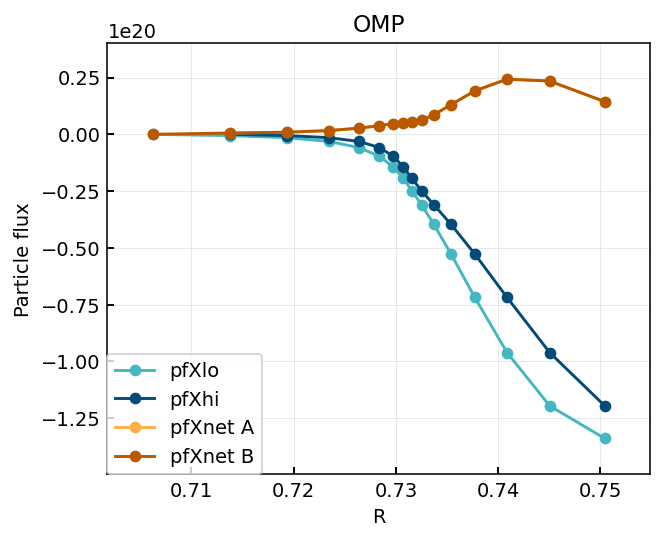

In [66]:
reg = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
title = "OMP"

fig, ax = plt.subplots()

kwargs = dict(marker = "o", ms = 5)
ax.plot(reg["R"], reg["pfXlo"], label = "pfXlo", **kwargs)
ax.plot(reg["R"], reg["pfXlo"].shift(x=1), label = "pfXhi", **kwargs)
ax.plot(reg["R"], reg["pfXlo"].shift(x=1) - reg["pfXlo"], label = "pfXnet A", **kwargs)
ax.plot(reg["R"], reg["pfXnet"], label = "pfXnet B", **kwargs)
# ax.plot(reg["R"], reg["pfXnet"], label = "pfXnet")
# ax.plot(reg["R"], reg["pfYnet"], label = "pfYnet")
# ax.plot(reg["R"], reg["pfNet"], label = "pfNet")
# ax.plot(reg["R"], iz, label = "iz")
# ax.plot(reg["R"], rec, label = "rec")
# ax.plot(reg["R"], pfBal, label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(reg["R"], reg["ddt(Nd)"], label = "ddt(Nd)", c = "k", lw = 4, alpha = 0.5)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)

# Net flow check - Y on field line

(0.8, 1.0288331727062188)

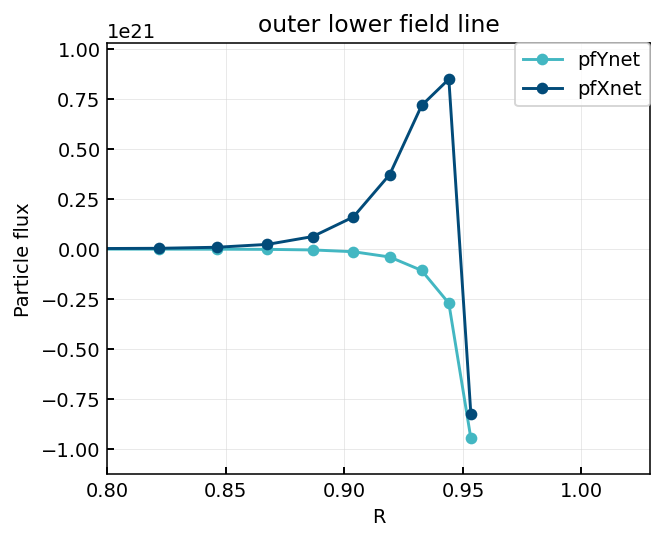

In [148]:
reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze()
title = "outer lower field line"

fig, ax = plt.subplots()
x = np.cumsum(reg["dl"]).values
kwargs = dict(marker = "o", ms = 5)
# ax.plot(x, reg["pfYlo"].values, label = "pfYlo", **kwargs)
# ax.plot(x, reg["pfYlo"].shift(theta=1), label = "pfYhi", **kwargs)
# ax.plot(x, reg["pfYlo"].shift(theta=1) - reg["pfYlo"], label = "pfYnet A", **kwargs)
ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(reg["R"], reg["pfYnet"], label = "pfYnet")
# ax.plot(reg["R"], reg["pfNet"], label = "pfNet")
# ax.plot(reg["R"], iz, label = "iz")
# ax.plot(reg["R"], rec, label = "rec")
# ax.plot(reg["R"], pfBal, label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(reg["R"], reg["ddt(Nd)"], label = "ddt(Nd)", c = "k", lw = 4, alpha = 0.5)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)
ax.set_xlim(0.8, None)

# Net flow check - puffs

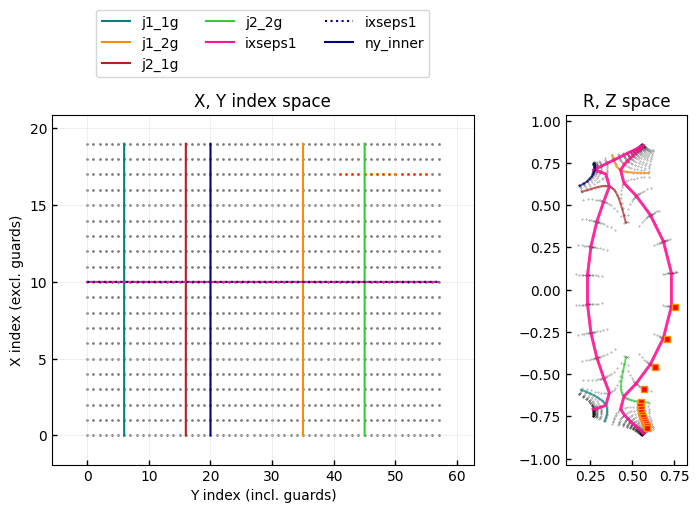

In [156]:
plot_selection(ds, ds.hermesm.select_custom_sol_ring(16, region = "outer_lower").squeeze())

Text(0.5, 1.0, 'outer lower field line')

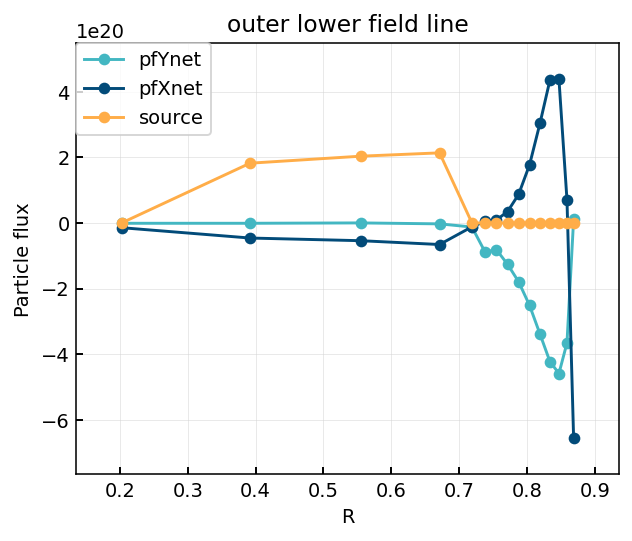

In [11]:
reg = ds.hermesm.select_custom_sol_ring(16, region = "outer_lower").squeeze()
title = "outer lower field line"

fig, ax = plt.subplots()
x = np.cumsum(reg["dl"]).values
kwargs = dict(marker = "o", ms = 5)
# ax.plot(x, reg["pfYlo"].values, label = "pfYlo", **kwargs)
# ax.plot(x, reg["pfYlo"].shift(theta=1), label = "pfYhi", **kwargs)
# ax.plot(x, reg["pfYlo"].shift(theta=1) - reg["pfYlo"], label = "pfYnet A", **kwargs)
ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
ax.plot(x, reg["Sd_src"]*reg["dv"], label = "source", **kwargs)
# ax.plot(reg["R"], reg["pfYnet"], label = "pfYnet")
# ax.plot(reg["R"], reg["pfNet"], label = "pfNet")
# ax.plot(reg["R"], iz, label = "iz")
# ax.plot(reg["R"], rec, label = "rec")
# ax.plot(reg["R"], pfBal, label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(reg["R"], reg["ddt(Nd)"], label = "ddt(Nd)", c = "k", lw = 4, alpha = 0.5)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)
# ax.set_xlim(0.8, None)

## Single cell
- Central puff
- Positive X flow is towards SOL
- Positive Y flow is towards target

In [22]:
ds["dv"].sum(["x","theta"]).values

array(1.60731633)

In [20]:
reg = ds.hermesm.select_custom_sol_ring(16, region = "outer_lower").squeeze().isel(theta=2)
print(f'FLOWS')
for param in ["pfXlo", "pfXhi", "pfYlo", "pfYhi", "pfXnet", "pfYnet"]:
    print(f'- {param}: {reg[param]:.2e}')
    
print(f'Total net flows: {reg["pfNet"]:.2e}')
    
print(f'\nSOURCES')
totsrc = 0
for param in ["Sd_src", "Sd_wall_recycle", "Sd+_iz"]:
    mult = -1 if "iz" in  param else 1
    src = reg[param]*reg["dv"]*mult / (2*np.pi)
    totsrc += src
    print(f'- {param}: {src:.2e}')
    
print(f'Total net sources: {totsrc:.2e}')
    



FLOWS
- pfXlo: -2.63e+20
- pfXhi: -2.09e+20
- pfYlo: -7.30e+17
- pfYhi: -9.27e+17
- pfXnet: -5.40e+19
- pfYnet: 1.97e+17
Total net flows: -5.39e+19

SOURCES
- Sd_src: 3.24e+19
- Sd_wall_recycle: 1.34e+19
- Sd+_iz: -5.10e+18
Total net sources: 4.07e+19


# OMP check

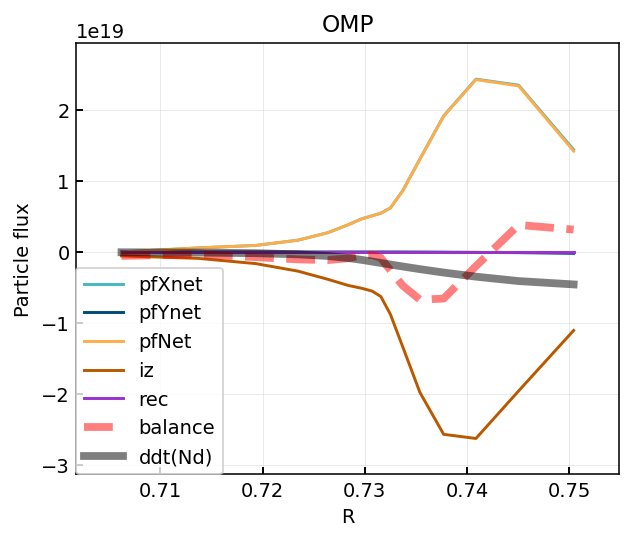

In [68]:




def plot_reg(reg, title):
    dv = reg["dv"]
    iz = reg["Sd+_iz"] * dv * -1

    if "Sd+_rec" in ds.data_vars:
        rec = reg["Sd+_rec"] * dv
    else:
        rec = reg["Sd+_iz"] / reg["Sd+_iz"]
        
    pfBal = reg["pfNet"] + iz + rec

    fig, ax = plt.subplots()

    ax.plot(reg["R"], reg["pfXnet"], label = "pfXnet")
    ax.plot(reg["R"], reg["pfYnet"], label = "pfYnet")
    ax.plot(reg["R"], reg["pfNet"], label = "pfNet")
    ax.plot(reg["R"], iz, label = "iz")
    ax.plot(reg["R"], rec, label = "rec")
    ax.plot(reg["R"], pfBal, label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
    ax.plot(reg["R"], reg["ddt(Nd)"], label = "ddt(Nd)", c = "k", lw = 4, alpha = 0.5)

    ax.set_xlabel("R")
    ax.set_ylabel("Particle flux")
    ax.set_title(title)

    ax.legend()

plot_reg(ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2)), "OMP")
# plot_reg(ds.hermesm.select_region("outer_lower_target").isel(x=slice(2,-2)), "lower outer target")
# ds.data_vars

# Target check

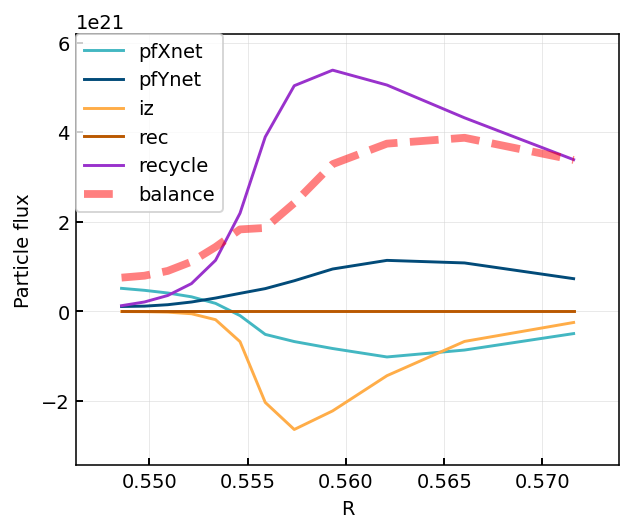

In [22]:


reg = ds.hermesm.select_region("outer_lower_target").isel(x=slice(2,-2))
dv = reg["dv"]
iz = reg["Sd+_iz"] * dv * -1

if "Sd+_rec" in ds.data_vars:
    rec = reg["Sd+_rec"] * dv
else:
    rec = reg["Sd+_iz"] / reg["Sd+_iz"]
    
pfBal = reg["pfNet"] + iz + rec

fig, ax = plt.subplots()

ax.plot(reg["R"], reg["pfXnet"], label = "pfXnet")
ax.plot(reg["R"], reg["pfYnet"], label = "pfYnet")
ax.plot(reg["R"], iz, label = "iz")
ax.plot(reg["R"], rec, label = "rec")
ax.plot(reg["R"], reg["Sd_target_recycle"] * reg["dv"], label = "recycle")
ax.plot(reg["R"], reg["pfBal"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")

ax.legend()

# ds.data_vars

# Field line check

(0.8, 1.0288331727062188)

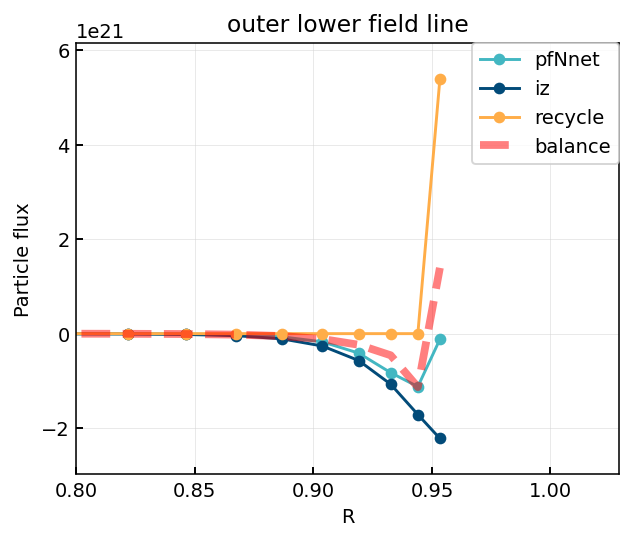

In [144]:
reg = ds.hermesm.select_custom_sol_ring(11, region = "outer_lower").squeeze().isel(theta = slice(None, None))
title = "outer lower field line"

fig, ax = plt.subplots()
x = np.cumsum(reg["dl"]).values
kwargs = dict(marker = "o", ms = 5)

# ax.plot(x, reg["pfXnet"], label = "pfXnet", **kwargs)
# ax.plot(x, reg["pfYnet"], label = "pfYnet", **kwargs)
ax.plot(x, reg["pfYnet"] + reg["pfXnet"]*-1, label = "pfNnet", **kwargs)
# ax.plot(x, reg["pfNet"], label = "pfNet", **kwargs)
ax.plot(x, reg["Sd+_iz"]*reg["dv"]*-1, label = "iz", **kwargs)

ax.plot(x, reg["Sd_target_recycle"]*reg["dv"], label = "recycle", **kwargs)
ax.plot(x, reg["pfBal"], label = "balance", c = "r", ls = "--", lw = 4, alpha = 0.5)
# ax.plot(reg["R"], reg["ddt(Nd)"], label = "ddt(Nd)", c = "k", lw = 4, alpha = 0.5)

# ax.plot(x, reg["Sd+_rec"]*reg["dv"]*-1, label = "rec", **kwargs)

ax.legend()
ax.set_xlabel("R")
ax.set_ylabel("Particle flux")
ax.set_title(title)
# ax.set_yscale()
ax.set_xscale("linear")
ax.set_xlim(0.8, None)

# 2D check

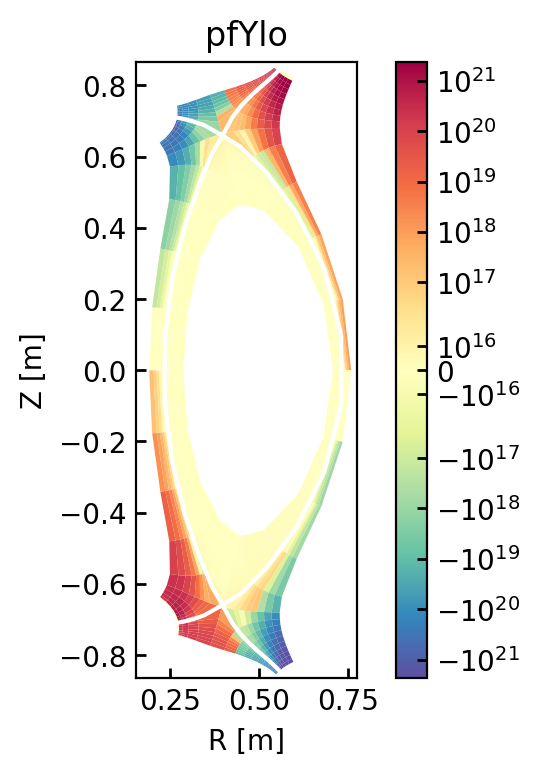

In [137]:
fig, ax = plt.subplots(dpi = 200)

((ds["pfYlo"]).hermesm.clean_guards()).bout.polygon(ax = ax, targets = False, 
                                                  separatrix_kwargs = {"color": "white", "linestyle" : "-"},
                                                  cmap = "Spectral_r", logscale = True,
                                                  antialias = True)
# ax.set_ylim(-0.9, -0.3)
ax.grid(visible = False)